## Global SP mode runs with different vertical scaling of respiration

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa


### Load FATES

In [2]:
fates_lloyd = '/pscratch/sd/j/jneedham/elm_runs/sp_cal/sp_f45_atkin_vert_4.Eb645be3aa2-Ff47577fa.2023-07-05/run/sp_f45_atkin_vert_4.Eb645be3aa2-Ff47577fa.2023-07-05.elm.h0.sofar.nc'
fates_lloyd = xr.open_dataset(fates_lloyd,  decode_times=False)

fates_lamour = '/pscratch/sd/j/jneedham/elm_runs/sp_cal/sp_f45_atkin_vert_2.Eb645be3aa2-Ff47577fa.2023-07-05/run/sp_f45_atkin_vert_2.Eb645be3aa2-Ff47577fa.2023-07-05.elm.h0.sofar.nc'
fates_lamour = xr.open_dataset(fates_lamour,  decode_times=False)

fates_atkin = '/pscratch/sd/j/jneedham/elm_runs/sp_cal/sp_f45_atkin_vert_1.Eb645be3aa2-Ff47577fa.2023-07-05/run/sp_f45_atkin_vert_1.Eb645be3aa2-Ff47577fa.2023-07-05.elm.h0.sofar.nc'
fates_atkin = xr.open_dataset(fates_atkin,  decode_times=False)
time = fates_atkin.variables['time'] / 365.
cohort_size_bins = fates_atkin.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

tave_start =  5
tave_stop = 10

pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

### GPP 

In [3]:
gpp_tmean_lloyd = fates_lloyd.FATES_GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365
gpp_tmean_lamour = fates_lamour.FATES_GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365
gpp_tmean_atkin = fates_atkin.FATES_GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365

lloyd_lamour = gpp_tmean_lloyd - gpp_tmean_lamour

Text(0.5, 1.0, 'GPP (Lloyd - Lamour)')

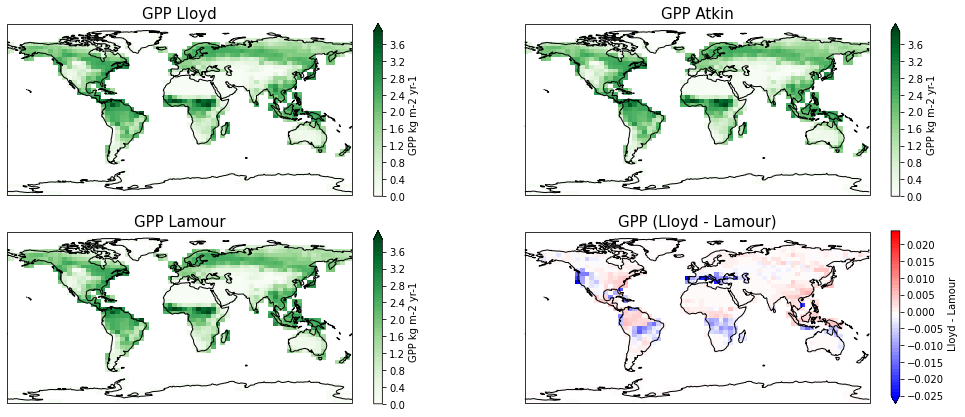

In [4]:
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(17,7))

clevs = np.arange(0.,4.0,0.1)
axs=axs.flatten()

gpp_tmean_lloyd.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "GPP kg m-2 yr-1"}, ax=axs[0])
axs[0].coastlines()
axs[0].set_title('GPP Lloyd', fontsize=15)

gpp_tmean_atkin.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "GPP kg m-2 yr-1"}, ax=axs[1])
axs[1].coastlines()
axs[1].set_title('GPP Atkin', fontsize=15)

gpp_tmean_lamour.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "GPP kg m-2 yr-1"}, ax=axs[2])
axs[2].coastlines()
axs[2].set_title('GPP Lamour', fontsize=15)


clevs = np.arange(-0.025,0.025,0.001)

lloyd_lamour.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='bwr',
         cbar_kwargs={"label": "Lloyd - Lamour"}, ax=axs[3])
axs[3].coastlines()
axs[3].set_title('GPP (Lloyd - Lamour)', fontsize=15)


In [5]:
def decay_coeff_kn(vcmax25top):
    ans = np.exp(0.00963 * vcmax25top - 2.43)
    return ans


def clllpf_to_cn_lf_by_pft(clllpf_var, dataset, dataset2):
    """function to reshape a fates multiplexed canopy layer, leaf layer and pft-indexed variable to one indexed by canopy layer leaf layer and pft
    first argument should be an xarray DataArray that has the FATES CLLLPF dimension
    second argument should be an xarray Dataset that has the FATES CLLL dimensions
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the cnlf  (CLLL) and pft dimensions disentangled"""
    n_cnlf = len(dataset.fates_levcnlf)
    ds_out = (clllpf_var.rolling(fates_levcnlfpf=n_cnlf, center=False)
            .construct("fates_levcnlf")
            .isel(fates_levcnlfpf=slice(n_cnlf-1, None, n_cnlf))
            .rename({'fates_levcnlfpf':'fates_levpft'})
            .assign_coords({'fates_levcnlf':dataset.fates_levcnlf})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = clllpf_var.attrs['long_name']
    ds_out.attrs['units'] = clllpf_var.attrs['units']
    
    # now create a new dimension - leaf layers - and disentangle canopy layers and leaf layers
    n_levleaf = len(dataset2.fates_levleaf)
    ds_out2 = (ds_out.rolling(fates_levcnlf=n_levleaf, center=False)
               .construct("fates_levleaf")
               .isel(fates_levcnlf=slice(n_levleaf-1, None, n_levleaf))
               .rename({'fates_levcnlf':'fates_levcan'})
               .assign_coords({'fates_levleaf':dataset2.fates_levleaf})
               .assign_coords({'fates_levcan':dataset.fates_levcan}))
    ds_out2.attrs['long_name'] = ds_out.attrs['long_name']
    ds_out2.attrs['units'] = ds_out.attrs['units']
    
    return(ds_out2)

### Calculate leaf construction cost per pft

In [6]:
# Leaf construction cost depends on cumulative LAI which corresponds to the leaf layer 
# dimension in CLLLPF. Therefore calculate leaf construction cost for each leaf layer and
# subtract from NET_C_UPTAKE_CLLLPF to get the full net C uptake. 

# PFT level parameters 
vcmax25top = [50, 62, 39, 61, 41, 58, 62, 54, 54, 78, 78, 78]
slatop = [0.012, 0.005, 0.024, 0.009, 0.03, 0.03, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
slamax = [0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
root_long = [1, 2, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
leaf_long = [1.5, 4, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
season_decid = [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
stress_decid = [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
grperc = [0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11]
l2fr = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ]

vai_top_bin_width = 0.1
vai_width_increase_factor = 1.1
nlevleaf = 37 # it is actually 36 but do 37 here to get midpoints
z = np.linspace(1,nlevleaf,nlevleaf)
dinc_vai = vai_top_bin_width * vai_width_increase_factor ** z
cumulative_lais = np.cumsum(dinc_vai)

lower = cumulative_lais[0:-1]
upper = cumulative_lais[1:]
leaf_layer_mids = (lower + upper)*0.5

# make a dataset that has a fates_levleaf dimension
data = np.arange(36)
locs = leaf_layer_mids
dataset2 = xr.DataArray(data, coords={'fates_levleaf':locs}, dims = 'fates_levleaf')


### Leaf costs

In [7]:
leaf_costs = []

# This is kg C m-2 yr-1 (per unit ground area?)
for pf in range(len(pftnames)):
    
    pft_kn = decay_coeff_kn(vcmax25top[pf])
    nscaler_levleaf = np.exp(-pft_kn * leaf_layer_mids)  
    sla_levleaf = slatop[pf] / nscaler_levleaf
    m = [idx for idx in range(len(sla_levleaf)) if sla_levleaf[idx] > slamax[pf]]
    sla_levleaf[m] = slamax[pf]
    
    # if deciduous
    if(season_decid[pf] == 1) or (stress_decid[pf] == 1):
        # account for sla profile 
        leaf_cost = 1 / (sla_levleaf * 1000) 
        # growth respiration tax
        leaf_cost = (leaf_cost * (grperc[pf] + 1))
    
    # if evergreen    
    else : 
        leaf_cost = (1 / (sla_levleaf * 1000 * leaf_long[pf])) 
        leaf_cost = (leaf_cost * (grperc[pf] + 1)) 
    
    bfr_per_bleaf = l2fr[pf]
    leaf_cost = leaf_cost + ( 1 / (sla_levleaf * 1000) * bfr_per_bleaf / root_long[pf] )
    
    # now subtract this leaf cost from the relevant dimensions
    leaf_costs.append(leaf_cost)
    
    
# subtract leaf construction  costs
leaf_costs = xr.DataArray(leaf_costs, dims = ['fates_levpft', 'fates_levleaf'], coords=[np.arange(len(l2fr))+1, leaf_layer_mids])    


### Lloyd

In [8]:
# untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
ds5_raw = clllpf_to_cn_lf_by_pft(fates_lloyd['FATES_NET_C_UPTAKE_CLLLPF'], fates_lloyd, dataset2) 

# max area of each pft in no comp
pft_frac = fates_lloyd.FATES_NOCOMP_PATCHAREA_PF  # in m2 m-2

# Subtract leaf costs from net C uptake ( make net C uptake annual)
ds5 = ds5_raw/pft_frac * (pft_frac/pft_frac) * 86400 * 365
ds6 = ds5 - leaf_costs

# Now in kg C m-2 yr-1

# average over time and remove empty canopy layers
# remove empty canopy layer
ds7 = ds6.isel(fates_levcan=0)

# mean over time
ds8 = ds7.mean(dim='time')

# sum over pfts
ds9 = (ds5_raw * 86400 * 365 - leaf_costs*pft_frac).isel(fates_levcan=0).mean(dim='time').sum(dim='fates_levpft')


### Atkin 

In [9]:
# untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
ds5_raw_atkin = clllpf_to_cn_lf_by_pft(fates_atkin['FATES_NET_C_UPTAKE_CLLLPF'], fates_atkin, dataset2) 

# max area of each pft in no comp
pft_frac_atkin = fates_atkin.FATES_NOCOMP_PATCHAREA_PF  # in m2 m-2

# Subtract leaf costs from net C uptake ( make net C uptake annual)
ds5_atkin = ds5_raw_atkin/pft_frac_atkin * (pft_frac_atkin/pft_frac_atkin) * 86400 * 365
ds6_atkin = ds5_atkin - leaf_costs

# Now in kg C m-2 yr-1

# average over time and remove empty canopy layers
# remove empty canopy layer
ds7_atkin = ds6_atkin.isel(fates_levcan=0)

# mean over time
ds8_atkin = ds7_atkin.mean(dim='time')

# sum over pfts
ds9_atkin = (ds5_raw_atkin * 86400 * 365 - leaf_costs*pft_frac_atkin).isel(fates_levcan=0).mean(dim='time').sum(dim='fates_levpft')


### Lamour

In [10]:
# untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
ds5_raw_lamour = clllpf_to_cn_lf_by_pft(fates_lamour['FATES_NET_C_UPTAKE_CLLLPF'], fates_lamour, dataset2) 

# max area of each pft in no comp
pft_frac_lamour = fates_lamour.FATES_NOCOMP_PATCHAREA_PF  # in m2 m-2

# Subtract leaf costs from net C uptake ( make net C uptake annual)
ds5_lamour = ds5_raw_lamour/pft_frac_lamour * (pft_frac_lamour/pft_frac_lamour) * 86400 * 365
ds6_lamour = ds5_lamour - leaf_costs

# Now in kg C m-2 yr-1

# average over time and remove empty canopy layers
# remove empty canopy layer
ds7_lamour = ds6_lamour.isel(fates_levcan=0)

# mean over time
ds8_lamour = ds7_lamour.mean(dim='time')

# sum over pfts
ds9_lamour = (ds5_raw_lamour * 86400 * 365 - leaf_costs*pft_frac_lamour).isel(fates_levcan=0).mean(dim='time').sum(dim='fates_levpft')


## equilibrium LAI for each PFT 

### Lloyd

In [11]:
lastpositivelevel = (ds8 > 0.).sum(dim='fates_levleaf')
equilibrium_lai = lastpositivelevel.copy()
for ipft in range(len(lastpositivelevel.fates_levpft)):
    for ilat in range(len(lastpositivelevel.lat)):
        for ilon in range(len(lastpositivelevel.lon)):
            if lastpositivelevel[ipft,ilat,ilon] > 0:
                equilibrium_lai[ipft,ilat,ilon] = leaf_layer_mids[lastpositivelevel[ipft,ilat,ilon]]
            else:
                equilibrium_lai[ipft,ilat,ilon] = np.nan
                
equilibrium_lai = equilibrium_lai * (ds8.sum(dim='fates_levleaf')/ds8.sum(dim='fates_levleaf'))


/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

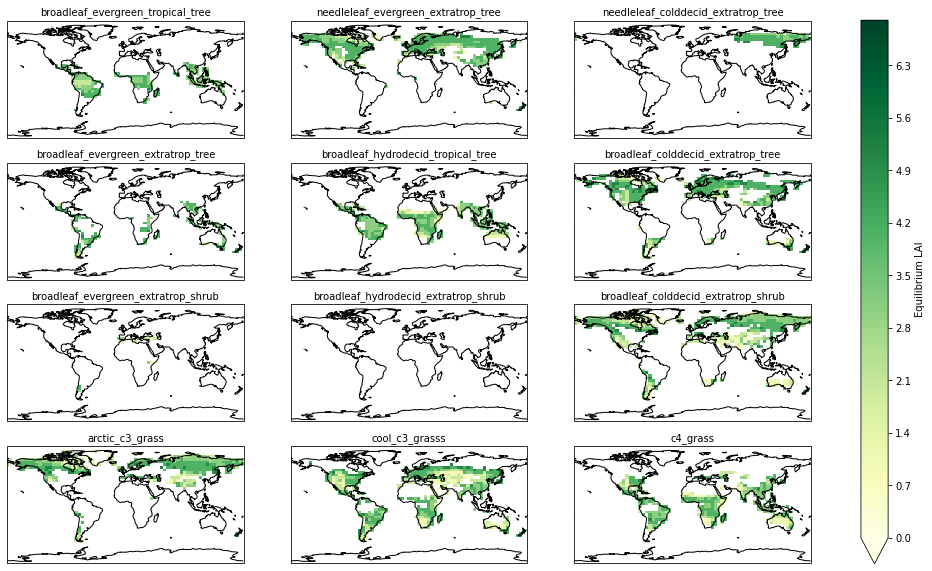

In [12]:
g = equilibrium_lai.plot(x="lon",y="lat",col="fates_levpft", col_wrap=3, 
           figsize=(18, 10),
      cbar_kwargs={"label": "Equilibrium LAI"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(0,7,0.1), cmap='YlGn',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pftnames[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

;

### Plot equilibrium LAI of tropical tree  for each vertical scheme

In [13]:
lastpositivelevel = (ds8_atkin > 0.).sum(dim='fates_levleaf')
equilibrium_lai_atkin = lastpositivelevel.copy()
for ipft in range(len(lastpositivelevel.fates_levpft)):
    for ilat in range(len(lastpositivelevel.lat)):
        for ilon in range(len(lastpositivelevel.lon)):
            if lastpositivelevel[ipft,ilat,ilon] > 0:
                equilibrium_lai_atkin[ipft,ilat,ilon] = leaf_layer_mids[lastpositivelevel[ipft,ilat,ilon]]
            else:
                equilibrium_lai_atkin[ipft,ilat,ilon] = np.nan
                
equilibrium_lai_atkin = equilibrium_lai_atkin * (ds8_atkin.sum(dim='fates_levleaf')/ds8_atkin.sum(dim='fates_levleaf'))


In [14]:
lastpositivelevel = (ds8_lamour > 0.).sum(dim='fates_levleaf')
equilibrium_lai_lamour = lastpositivelevel.copy()
for ipft in range(len(lastpositivelevel.fates_levpft)):
    for ilat in range(len(lastpositivelevel.lat)):
        for ilon in range(len(lastpositivelevel.lon)):
            if lastpositivelevel[ipft,ilat,ilon] > 0:
                equilibrium_lai_lamour[ipft,ilat,ilon] = leaf_layer_mids[lastpositivelevel[ipft,ilat,ilon]]
            else:
                equilibrium_lai_lamour[ipft,ilat,ilon] = np.nan
                
equilibrium_lai_lamour = equilibrium_lai_lamour * (ds8_lamour.sum(dim='fates_levleaf')/ds8_lamour.sum(dim='fates_levleaf'))


In [15]:
print(equilibrium_lai_lamour.dims)

('fates_levpft', 'lat', 'lon')


''

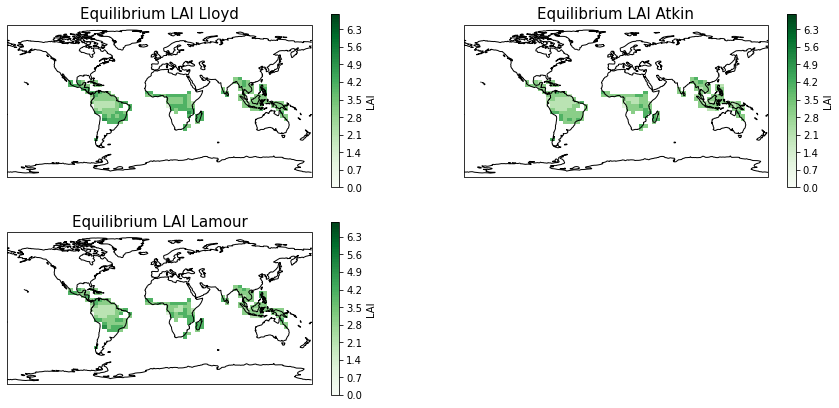

In [16]:
fig2, ((f2ax0,f2ax1), (f2ax2,f2ax3)) = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,7))

clevs = np.arange(0.,7.0,0.1)

equilibrium_lai.isel(fates_levpft=0).plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "LAI"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('Equilibrium LAI Lloyd', fontsize=15)

equilibrium_lai_atkin.isel(fates_levpft=0).plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "LAI"}, ax=f2ax1)
f2ax1.coastlines()
f2ax1.set_title('Equilibrium LAI Atkin', fontsize=15)

equilibrium_lai_lamour.isel(fates_levpft=0).plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "LAI"}, ax=f2ax2)
f2ax2.coastlines()
f2ax2.set_title('Equilibrium LAI Lamour', fontsize=15)

f2ax3.axis('off')
;

### Plot solar 

In [78]:
solar = '/pscratch/sd/j/jneedham/solr_tmp/fsds_timeave.nc'
solar = xr.open_dataset(solar,  decode_times=False)

In [79]:
FSDS = solar.FSDS.mean(dim='time')
FSDS.dims

('lat', 'lon')

In [80]:
latcoord = solar.LATIXY.isel(lon=0).values
loncoord = solar.LONGXY.isel(lat=0).values

In [81]:
FSDS = FSDS.assign_coords({'lon':loncoord})
FSDS = FSDS.assign_coords({'lat':latcoord})

In [82]:
print(FSDS.coords)

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75


In [83]:
print(FSDS.shape)

(360, 720)


Text(0.5, 1.0, 'FSDS')

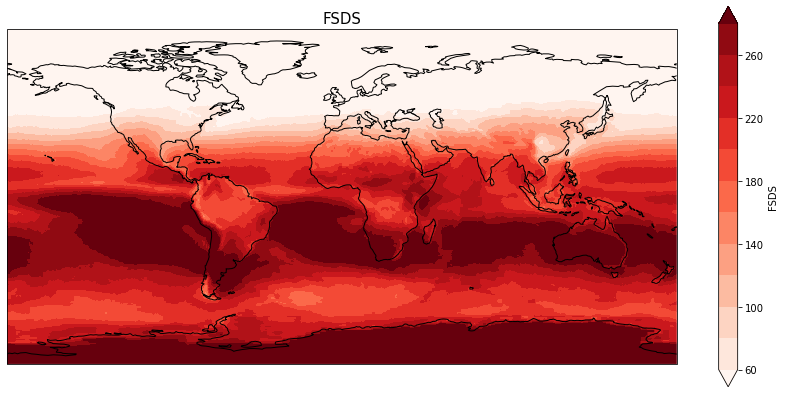

In [84]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,7))

clevs = np.arange(60,300,20)

FSDS.plot(levels=clevs,transform=ccrs.PlateCarree(),cmap='Reds',
         cbar_kwargs={"label": "FSDS"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('FSDS', fontsize=15)


In [23]:
FSDS.coords

Coordinates:
    *empty*